# Correlation Analysis

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

class FrequencyCorrelationAnalyzer:
    def __init__(self, df, col1, col2, normalize: bool = False, bins: np.ndarray = None):
        """
        단어 빈도수 컬럼 간 상관관계 분석 클래스
        
        Parameters:
        df: pandas DataFrame
        col1: 첫 번째 빈도수 컬럼명
        col2: 두 번째 빈도수 컬럼명
        """
        self.df = df.copy()
        self.col1 = col1
        self.col2 = col2
        self.normalize = normalize
        self.bins = bins

        if self.normalize:
            self.scaler = {
                'col1': StandardScaler(),
                'col2': StandardScaler()
            }
        
        # 결측값 제거
        self.df_clean = self.df[[col1, col2]].dropna()
    
    def normalize_col(self):
        self.df_clean[self.col1] = self.scaler['col1'].fit_transform(self.df_clean[self.col1].values.reshape(-1, 1))
        self.df_clean[self.col2] = self.scaler['col2'].fit_transform(self.df_clean[self.col2].values.reshape(-1, 1))
        
    def calculate_correlation(self):
        """상관계수 계산"""
        # 피어슨 상관계수 (선형 관계)
        pearson_corr, pearson_p = stats.pearsonr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 스피어만 상관계수 (순위 관계)
        spearman_corr, spearman_p = stats.spearmanr(self.df_clean[self.col1], self.df_clean[self.col2])
        
        # 켄달 타우 (순위 관계)
        kendall_corr, kendall_p = stats.kendalltau(self.df_clean[self.col1], self.df_clean[self.col2])
        
        return {
            'pearson': {'correlation': pearson_corr, 'p_value': pearson_p},
            'spearman': {'correlation': spearman_corr, 'p_value': spearman_p},
            'kendall': {'correlation': kendall_corr, 'p_value': kendall_p}
        }
    
    def plot_scatter(self, figsize=(10, 8)):
        """산점도 그리기"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # 원본 데이터 산점도
        ax1.scatter(self.df_clean[self.col1], self.df_clean[self.col2], alpha=0.6)
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel(self.col2)
        ax1.set_title(f'{self.col1} vs {self.col2} (원본 데이터)')
        ax1.grid(True, alpha=0.3)
        
        # 로그 변환된 데이터 산점도 (빈도수 데이터에 유용)
        log_col1 = np.log1p(self.df_clean[self.col1])  # log(1+x) 변환
        log_col2 = np.log1p(self.df_clean[self.col2])
        
        ax2.scatter(log_col1, log_col2, alpha=0.6, color='orange')
        ax2.set_xlabel(f'log(1 + {self.col1})')
        ax2.set_ylabel(f'log(1 + {self.col2})')
        ax2.set_title(f'{self.col1} vs {self.col2} (로그 변환)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_heatmap(self, figsize=(8, 6)):
        """상관계수 히트맵"""
        corr_matrix = self.df_clean.corr()
        
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.3f')
        plt.title('상관계수 히트맵')
        plt.show()
    
    def plot_distribution(self, figsize=(12, 5)):
        """분포 시각화"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        # 현재 그리는 분포는 규모가 서로 다르므로, 다른 bin 값을 적용할 필요가 있음.
        if not self.normalize and self.bins is None:
            bins = 30
        elif self.normalize and self.bins is None:
            bins = np.arange(-1.5, 1.5, 0.1)
        else:
            bins = self.bins

        # 첫 번째 컬럼 분포
        ax1.hist(self.df_clean[self.col1], bins=bins, alpha=0.7, color='skyblue')
        ax1.set_xlabel(self.col1)
        ax1.set_ylabel('빈도')
        ax1.set_title(f'{self.col1} 분포')
        ax1.grid(True, alpha=0.3)
        
        # 두 번째 컬럼 분포
        ax2.hist(self.df_clean[self.col2], bins=bins, alpha=0.7, color='lightcoral')
        ax2.set_xlabel(self.col2)
        ax2.set_ylabel('빈도')
        ax2.set_title(f'{self.col2} 분포')
        ax2.grid(True, alpha=0.3)
        
        # 박스플롯
        ax3.boxplot([self.df_clean[self.col1], self.df_clean[self.col2]], 
                   labels=[self.col1, self.col2])
        ax3.set_ylabel('빈도수')
        ax3.set_title('박스플롯 비교')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """분석 결과 요약 출력"""
        print("=" * 60)
        print("단어 빈도수 상관관계 분석 결과")
        print("=" * 60)
        
        # 기본 통계
        print(f"\n📊 기본 통계:")
        print(f"데이터 개수: {len(self.df_clean)}")
        print(f"{self.col1} - 평균: {self.df_clean[self.col1].mean():.2f}, 표준편차: {self.df_clean[self.col1].std():.2f}")
        print(f"{self.col2} - 평균: {self.df_clean[self.col2].mean():.2f}, 표준편차: {self.df_clean[self.col2].std():.2f}")
        
        # 상관계수
        corr_results = self.calculate_correlation()
        
        print(f"\n🔗 상관계수:")
        print(f"피어슨 상관계수: {corr_results['pearson']['correlation']:.4f} (p-value: {corr_results['pearson']['p_value']:.4f})")
        print(f"스피어만 상관계수: {corr_results['spearman']['correlation']:.4f} (p-value: {corr_results['spearman']['p_value']:.4f})")
        print(f"켄달 타우: {corr_results['kendall']['correlation']:.4f} (p-value: {corr_results['kendall']['p_value']:.4f})")
        
        # 해석
        print(f"\n📝 해석:")
        pearson_corr = corr_results['pearson']['correlation']
        pearson_p = corr_results['pearson']['p_value']
        
        if pearson_p < 0.001:
            significance = "매우 유의함 (p < 0.001)"
        elif pearson_p < 0.01:
            significance = "매우 유의함 (p < 0.01)"
        elif pearson_p < 0.05:
            significance = "유의함 (p < 0.05)"
        else:
            significance = "유의하지 않음 (p >= 0.05)"
        
        print(f"통계적 유의성: {significance}")
        
        if abs(pearson_corr) >= 0.8:
            strength = "매우 강한"
        elif abs(pearson_corr) >= 0.6:
            strength = "강한"
        elif abs(pearson_corr) >= 0.4:
            strength = "중간 정도의"
        elif abs(pearson_corr) >= 0.2:
            strength = "약한"
        else:
            strength = "매우 약한"
        
        direction = "양의" if pearson_corr > 0 else "음의"
        print(f"상관관계 강도: {strength} {direction} 상관관계")
        
        print("=" * 60)
    
    def run_full_analysis(self):
        """전체 분석 실행"""
        if self.normalize:
            self.normalize_col()
        self.print_summary()
        self.plot_scatter()
        self.plot_heatmap()
        self.plot_distribution()

# 사용 예시 함수
def analyze_word_frequency_correlation(df: pd.DataFrame, col1: str, col2: str, normalize: bool = False, bins: np.ndarray = None):
    """
    단어 빈도수 컬럼 간 상관관계 분석을 실행하는 편의 함수
    
    Parameters:
    df: pandas DataFrame
    col1: 첫 번째 빈도수 컬럼명
    col2: 두 번째 빈도수 컬럼명
    normalize: 정규화 여부
    bins: 분포 시각화 시 사용할 bin 값
    """
    analyzer = FrequencyCorrelationAnalyzer(df, col1, col2, normalize, bins)
    analyzer.run_full_analysis()
    return analyzer

## file validity check.

In [3]:
import os
from pathlib import Path

# 파일 경로 확인.
proj_path = os.path.dirname(os.path.dirname(Path.cwd()))
corpora_dir = os.path.join(proj_path, 'Corpora')
CSAT_json_path = save_path = os.path.join(corpora_dir, 'CSAT-latest')

# 파일 경로 유효성 확인.
if not os.path.exists(proj_path):
    raise FileNotFoundError(f"Project path not found at {proj_path}")
if not os.path.exists(CSAT_json_path):
    raise FileNotFoundError(f"CSAT json path not found at {CSAT_json_path}")
if not any(file.endswith('.json') for file in os.listdir(CSAT_json_path)):
    raise FileExistsError(f"Any .json file doesn't exist in {CSAT_json_path}")
print("All file paths are valid.")

All file paths are valid.


## HAL vs SUBTLEX

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_excel(os.path.join(corpora_dir, 'merged_corpora', 'CSAT_E_lexicon.xlsx'))
df

,Word,Length,CSAT_Freq,CSAT_only_Freq,Textbook_only_Freq,Freq_HAL,SUBTLWF,CSAT_RFreq,CSAT_only_RFreq,Textbook_only_RFreq,Ortho_N_CSAT,Ortho_N_CSAT(only),Ortho_N_Textbook(only),Ortho_N,OLD20_CSAT,OLD20_CSAT(only),OLD20_Textbook(only),OLD,SUBTLCD,POS
0,a,1,1284.0,1098.0,186.0,10610626,20415.27,0.001284,0.001098,0.000186,1.0,1.0,1.0,1,1.5,1.5,1.65,1.45,99.93,minor|NN
1,aah,3,NaN,NaN,NaN,222,52.71,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,1.85,7.56,NaN
2,aaron,5,NaN,NaN,NaN,10806,14.65,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,1.85,1.93,NN
3,aback,5,NaN,NaN,NaN,387,0.29,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1.95,0.18,RB
4,abacus,6,NaN,NaN,NaN,513,0.24,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2.90,0.12,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,zoom,4,NaN,NaN,NaN,4920,3.55,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,1.70,1.29,VB|NN
40477,zooming,7,NaN,NaN,NaN,523,0.63,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,1.85,0.31,VB
40478,zooms,5,NaN,NaN,NaN,385,0.06,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,1.80,0.04,VB
40479,zucchini,8,NaN,NaN,NaN,314,0.96,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3.75,0.25,NN


단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 35515
Freq_HAL - 평균: 0.00, 표준편차: 1.00
SUBTLWF - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.7993 (p-value: 0.0000)
스피어만 상관계수: 0.8020 (p-value: 0.0000)
켄달 타우: 0.6132 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


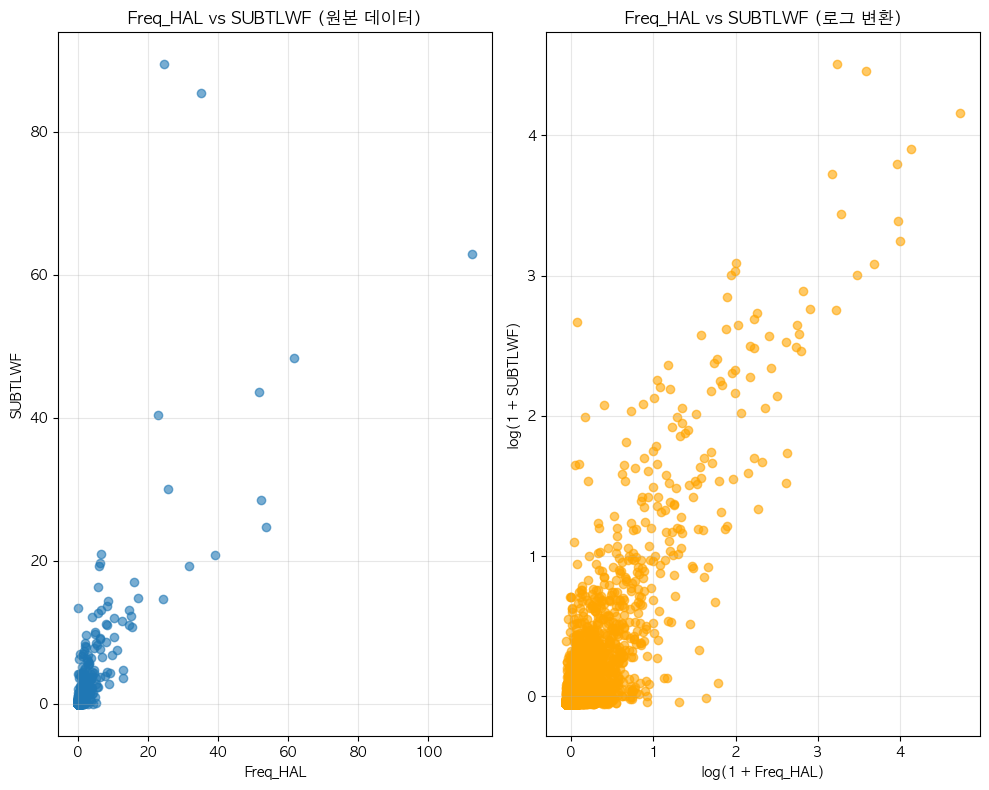

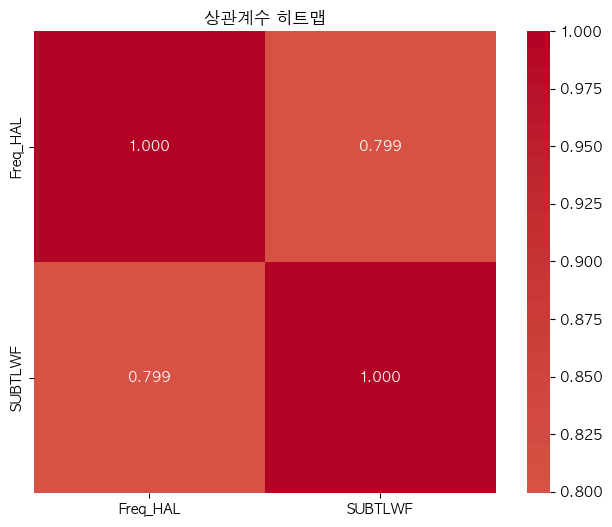

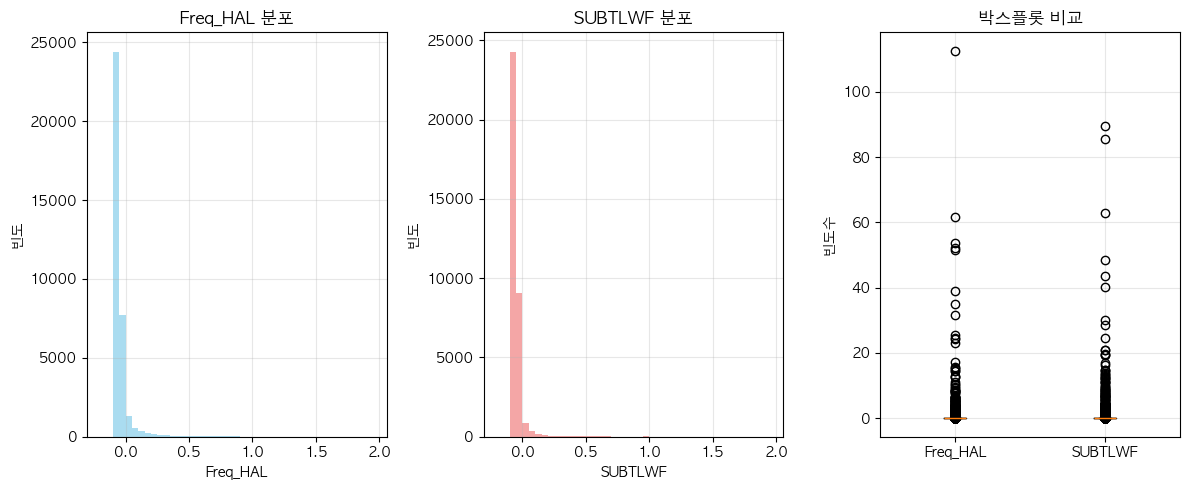

In [43]:
analyzer = analyze_word_frequency_correlation(df, 'Freq_HAL', 'SUBTLWF', normalize=True, bins=np.arange(-.2, 2, 0.05))

## CSAT(only) vs Textbook(only)

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 1524
CSAT_only_Freq - 평균: 0.00, 표준편차: 1.00
Textbook_only_Freq - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9745 (p-value: 0.0000)
스피어만 상관계수: 0.6237 (p-value: 0.0000)
켄달 타우: 0.5169 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


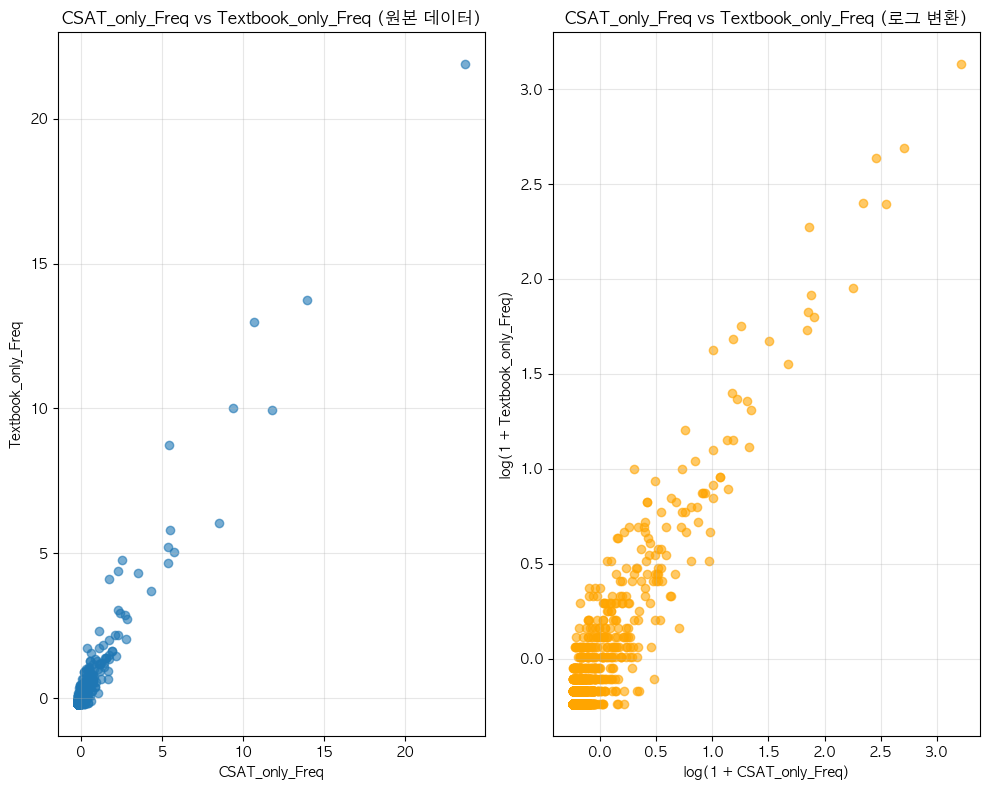

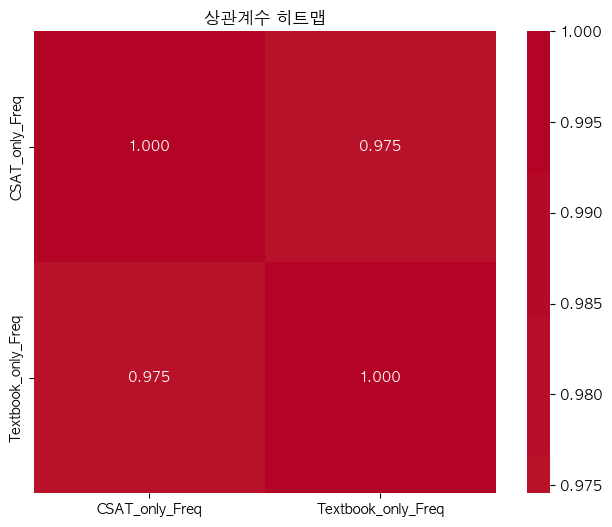

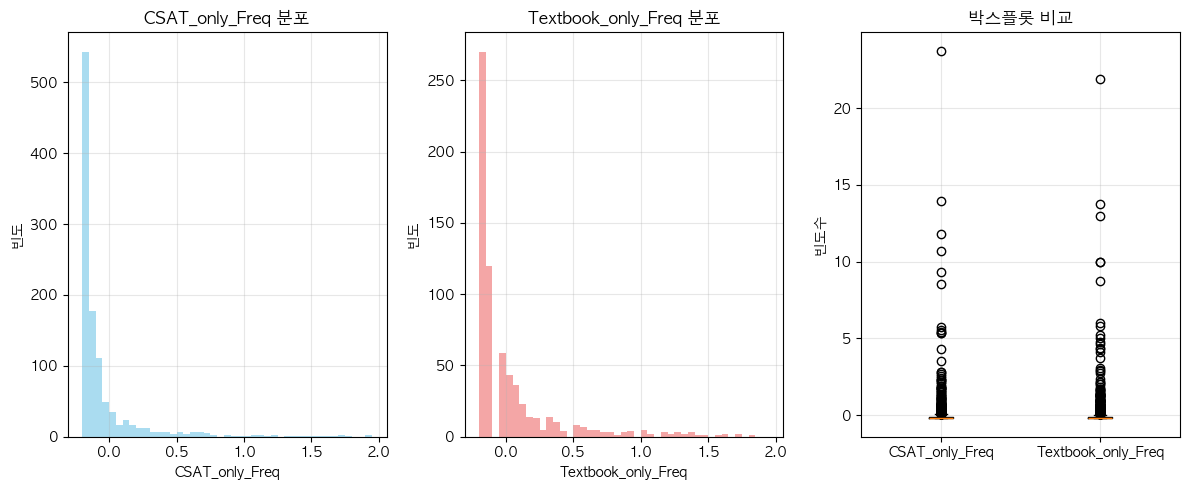

In [44]:
analyzer = analyze_word_frequency_correlation(df, 'CSAT_only_Freq', 'Textbook_only_Freq', normalize=True, bins=np.arange(-.2, 2, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 1524
Ortho_N_CSAT(only) - 평균: -0.00, 표준편차: 1.00
Ortho_N_Textbook(only) - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.8512 (p-value: 0.0000)
스피어만 상관계수: 0.7993 (p-value: 0.0000)
켄달 타우: 0.7434 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


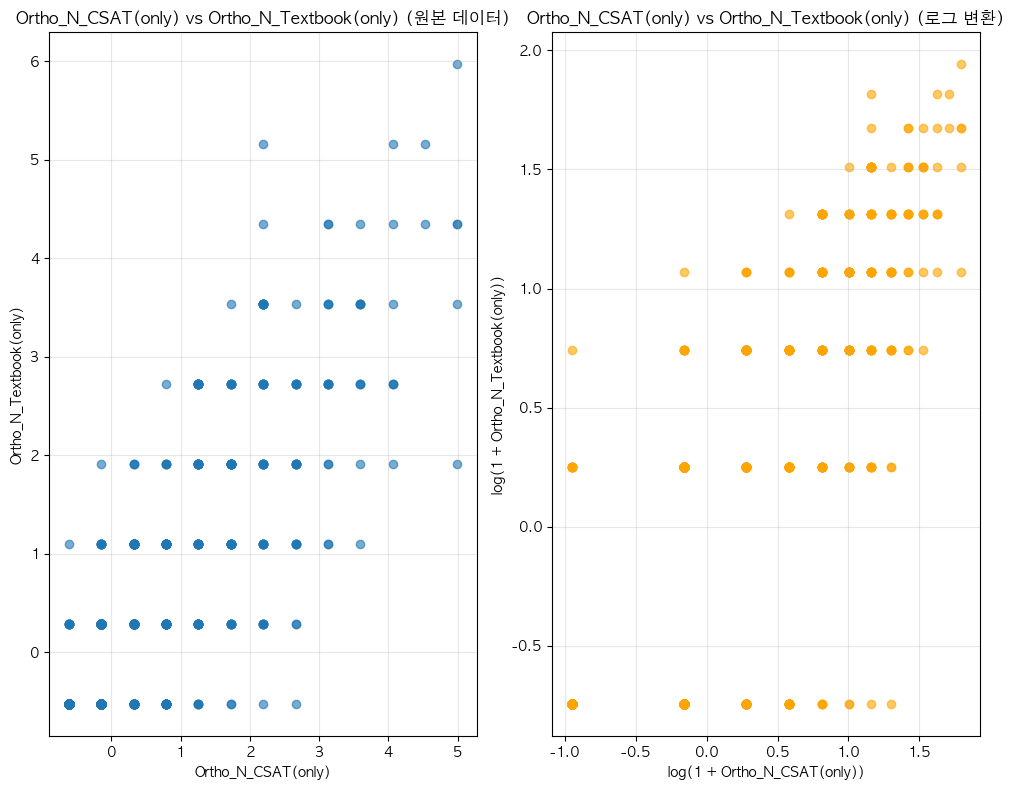

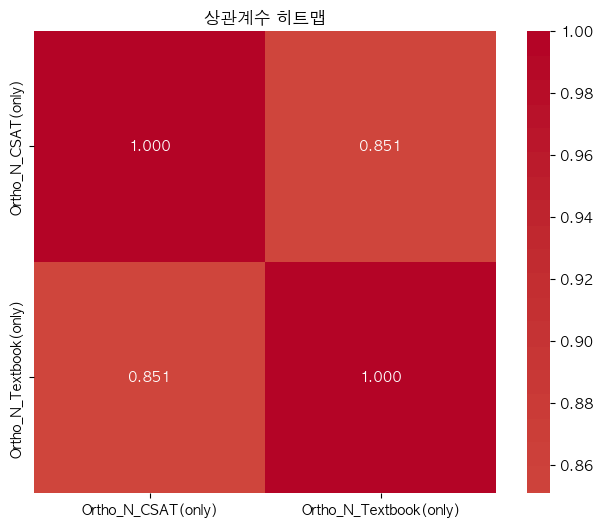

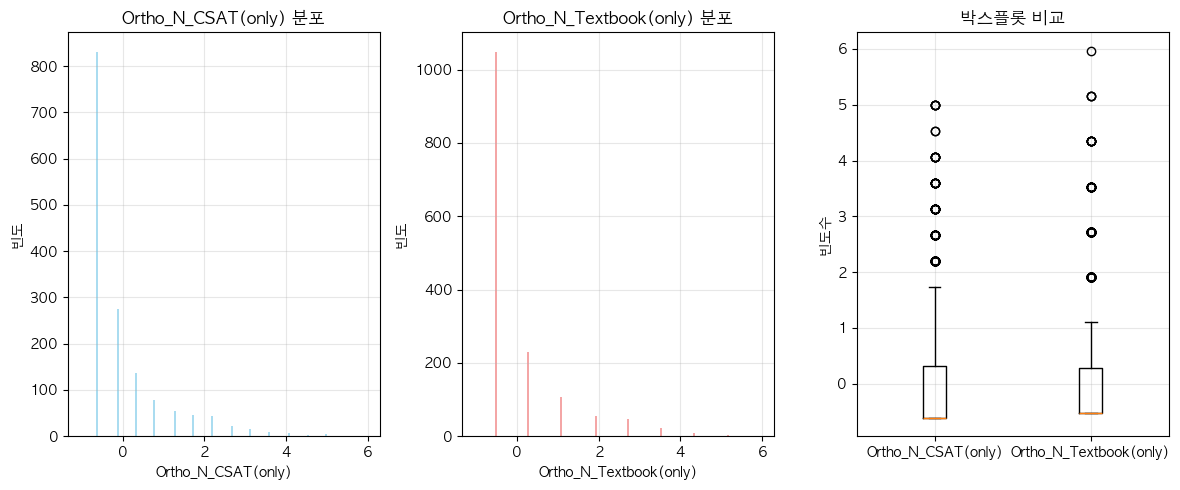

In [45]:
analyzer = analyze_word_frequency_correlation(df, 'Ortho_N_CSAT(only)', 'Ortho_N_Textbook(only)', normalize=True, bins=np.arange(-1, 6, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 1524
OLD20_CSAT(only) - 평균: -0.00, 표준편차: 1.00
OLD20_Textbook(only) - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9694 (p-value: 0.0000)
스피어만 상관계수: 0.9701 (p-value: 0.0000)
켄달 타우: 0.8639 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


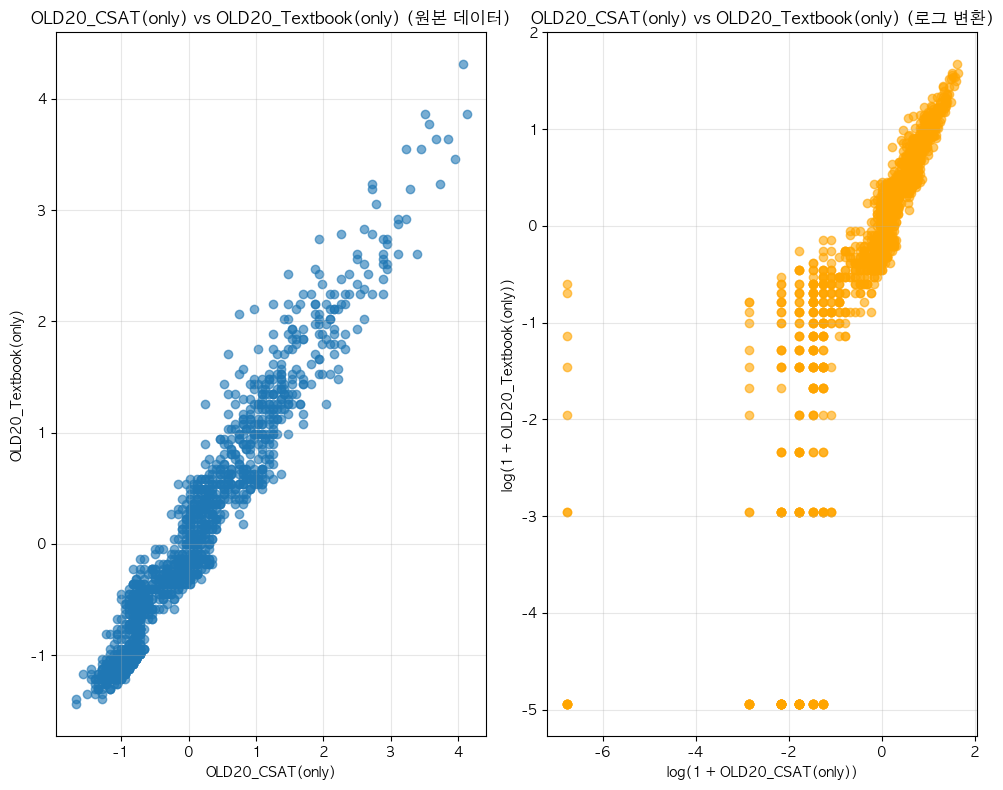

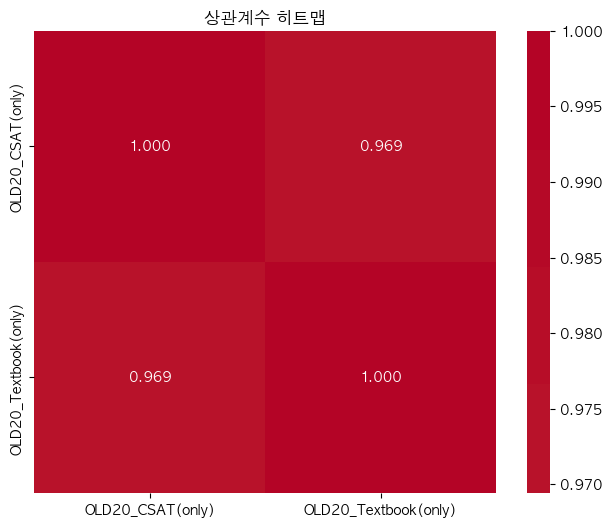

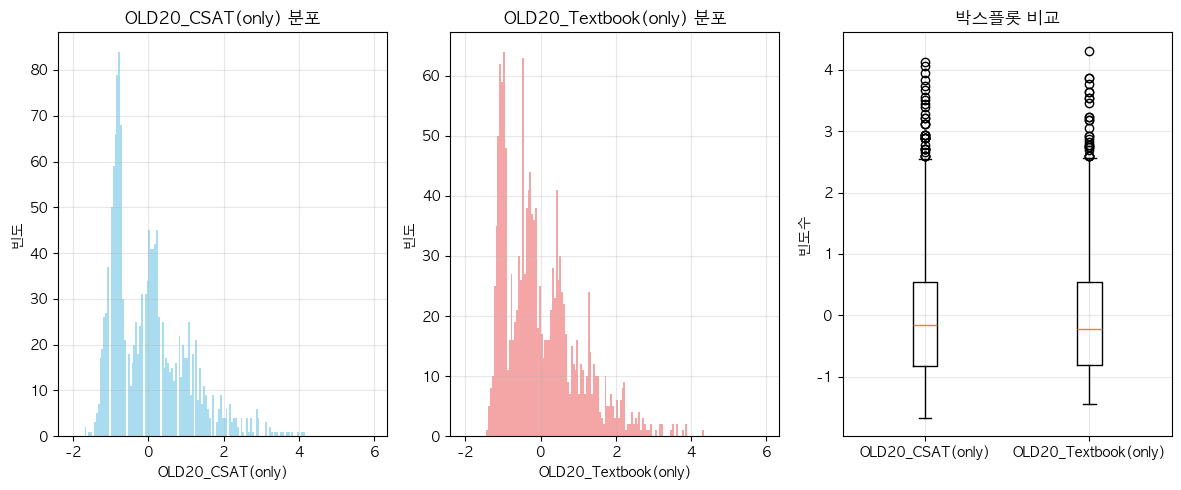

In [46]:
analyzer = analyze_word_frequency_correlation(df, 'OLD20_CSAT(only)', 'OLD20_Textbook(only)', normalize=True, bins=np.arange(-2, 6, 0.05))

## CSAT vs HAL

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6915
CSAT_Freq - 평균: 0.00, 표준편차: 1.00
Freq_HAL - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9861 (p-value: 0.0000)
스피어만 상관계수: 0.6761 (p-value: 0.0000)
켄달 타우: 0.5364 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


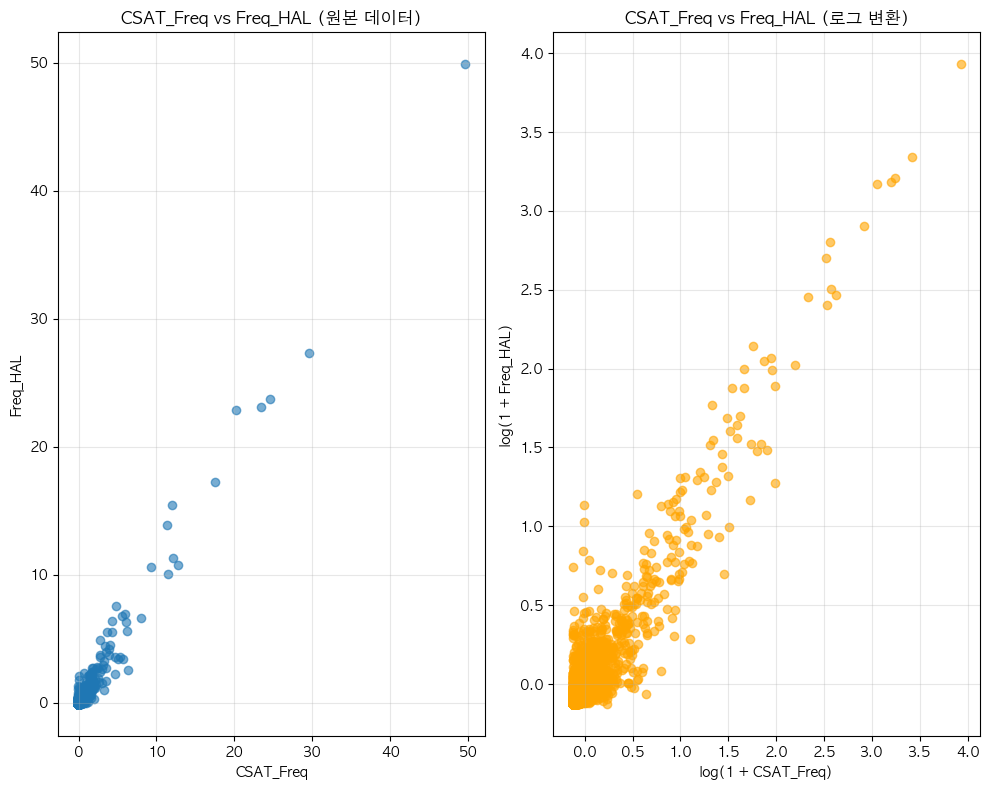

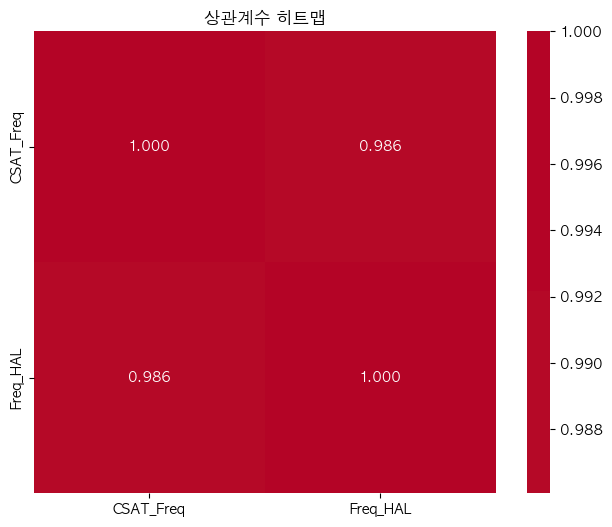

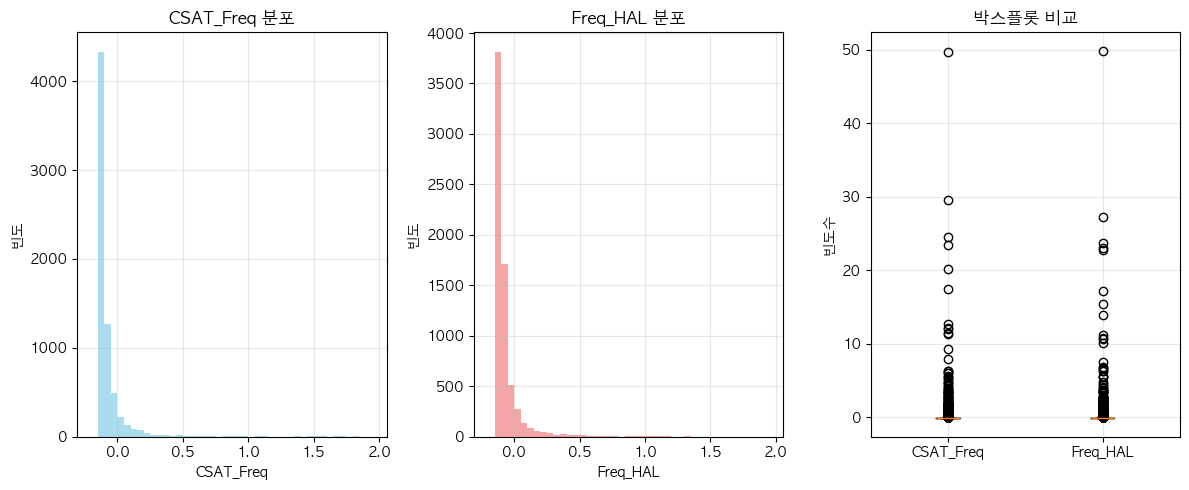

In [49]:
analyzer = analyze_word_frequency_correlation(df, 'CSAT_Freq', 'Freq_HAL', normalize=True, bins=np.arange(-.2, 2, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6915
CSAT_RFreq - 평균: 0.00, 표준편차: 1.00
Freq_HAL - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9861 (p-value: 0.0000)
스피어만 상관계수: 0.6761 (p-value: 0.0000)
켄달 타우: 0.5364 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


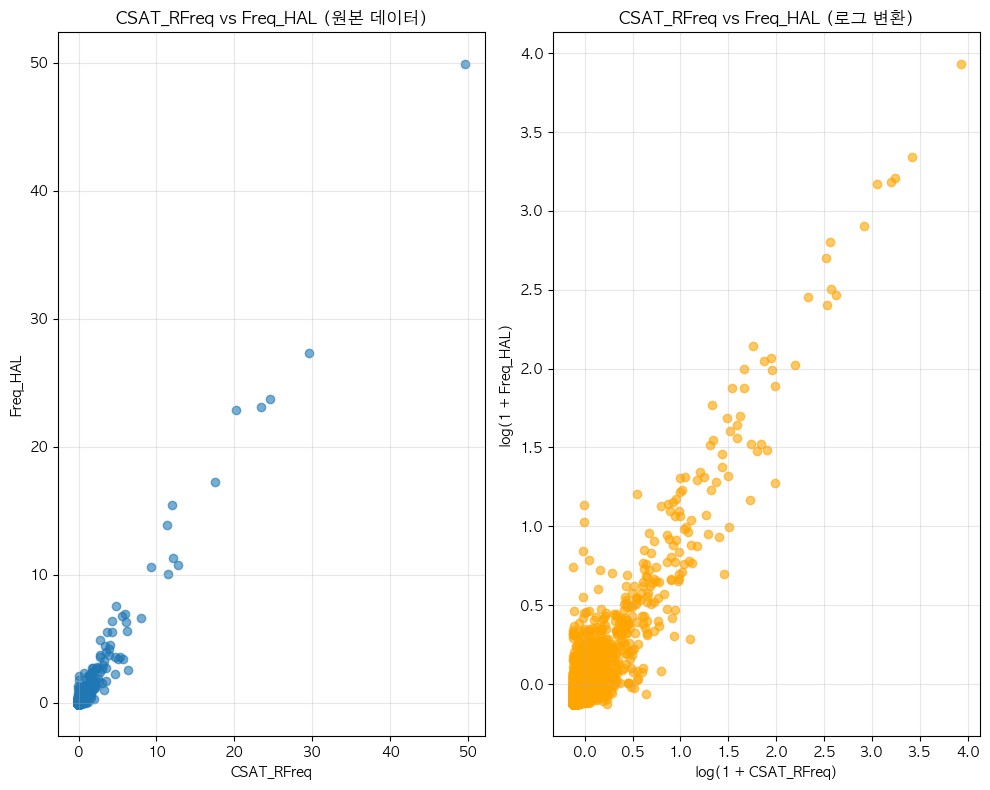

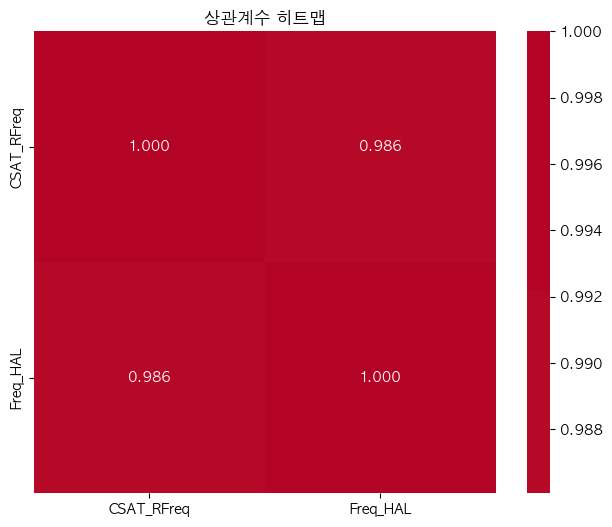

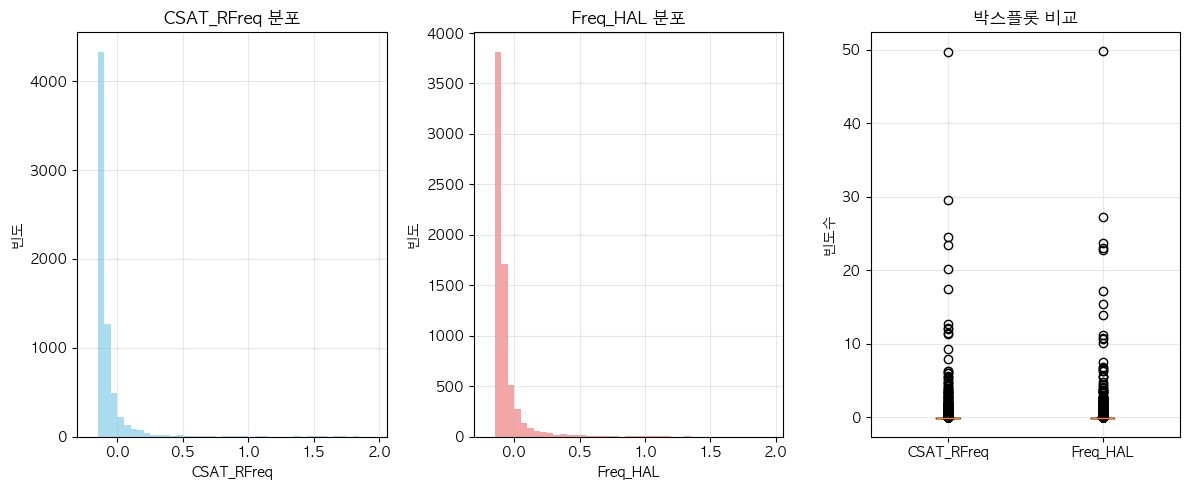

In [50]:
# 100만 token 단위로 변환한 상대빈도라도 결국 transformation이 linear하니, corr는 변하지 않음.
analyzer = analyze_word_frequency_correlation(df, 'CSAT_RFreq', 'Freq_HAL', normalize=True, bins=np.arange(-.2, 2, 0.05))

In [52]:
df.columns

Index(['Word', 'Length', 'CSAT_Freq', 'CSAT_only_Freq', 'Textbook_only_Freq',
       'Freq_HAL', 'SUBTLWF', 'CSAT_RFreq', 'CSAT_only_RFreq',
       'Textbook_only_RFreq', 'Ortho_N_CSAT', 'Ortho_N_CSAT(only)',
       'Ortho_N_Textbook(only)', 'Ortho_N', 'OLD20_CSAT', 'OLD20_CSAT(only)',
       'OLD20_Textbook(only)', 'OLD', 'SUBTLCD', 'POS'],
      dtype='object')

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 1906
OLD - 평균: -0.00, 표준편차: 1.00
OLD20_Textbook(only) - 평균: -0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9401 (p-value: 0.0000)
스피어만 상관계수: 0.9393 (p-value: 0.0000)
켄달 타우: 0.7989 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


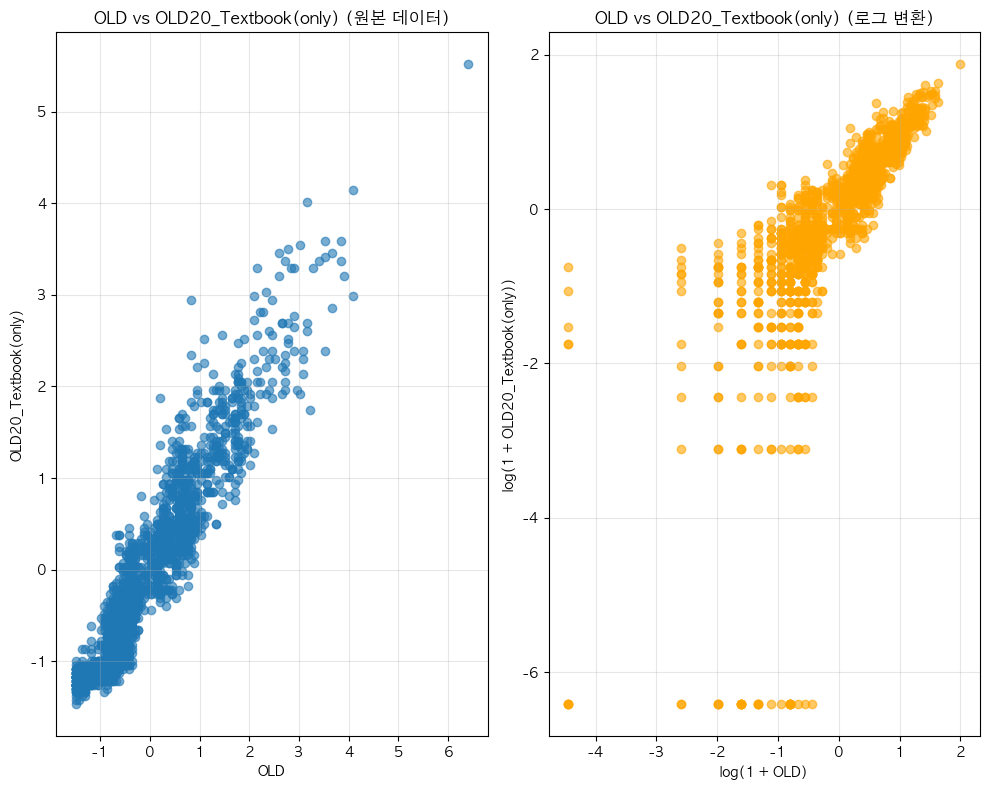

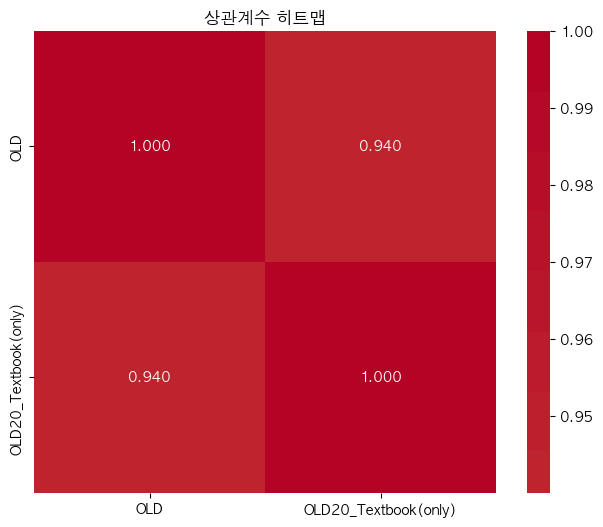

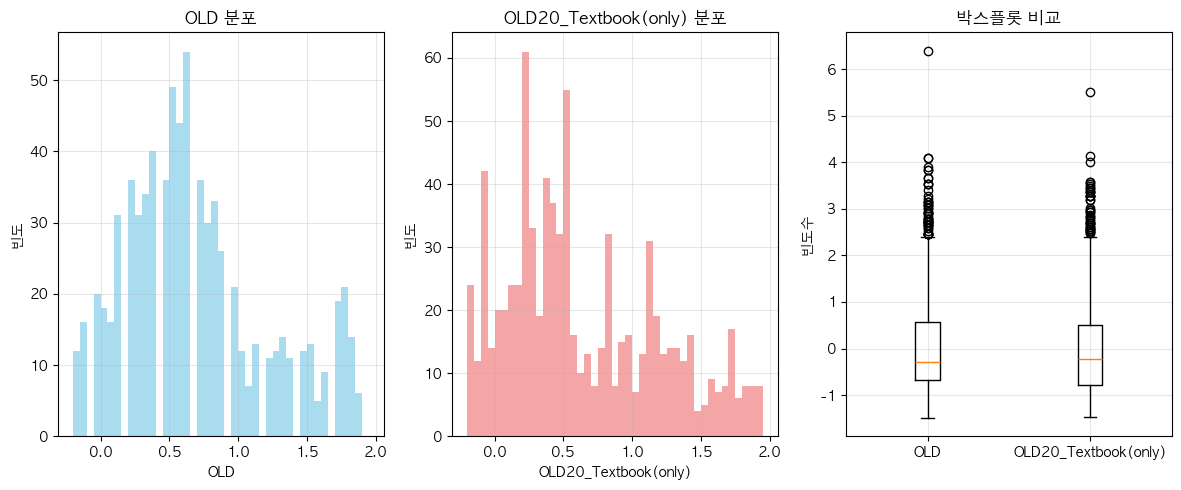

In [53]:
analyzer = analyze_word_frequency_correlation(df, 'OLD', 'OLD20_Textbook(only)', normalize=True, bins=np.arange(-.2, 2, 0.05))

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6495
OLD - 평균: 0.00, 표준편차: 1.00
OLD20_CSAT(only) - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.9606 (p-value: 0.0000)
스피어만 상관계수: 0.9641 (p-value: 0.0000)
켄달 타우: 0.8491 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 매우 강한 양의 상관관계


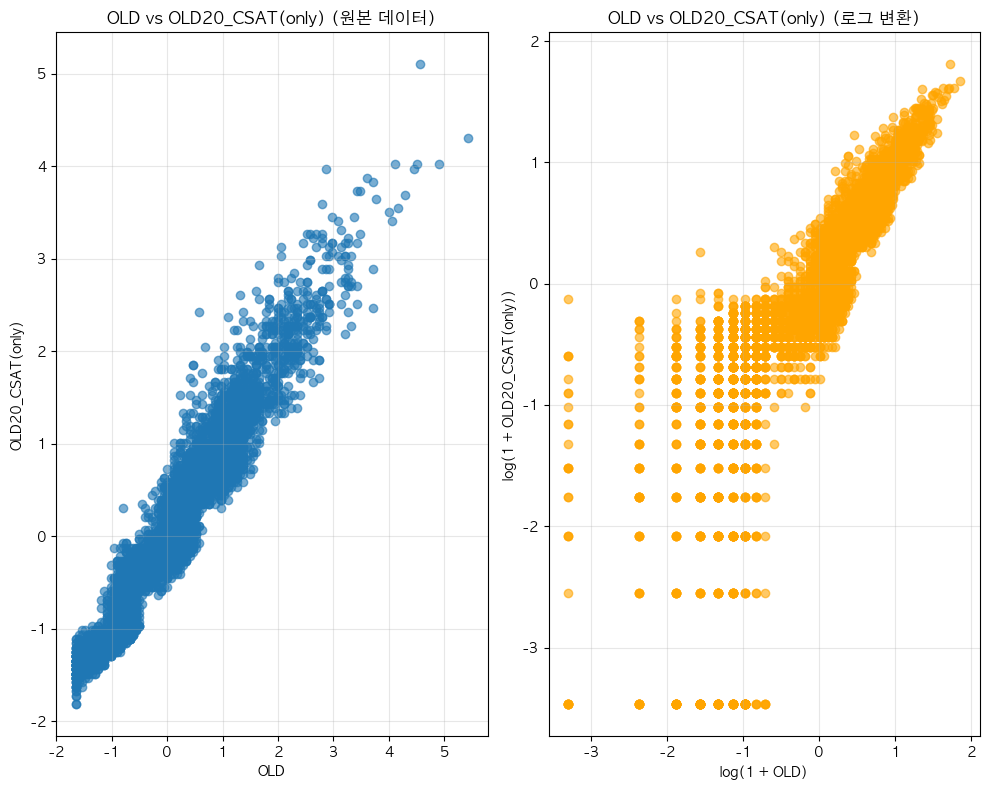

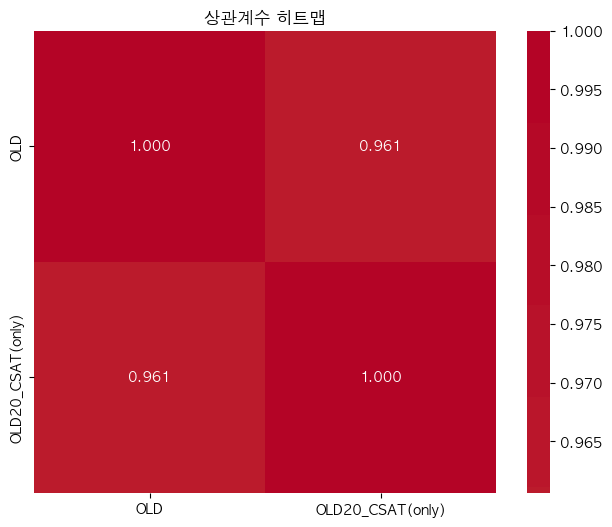

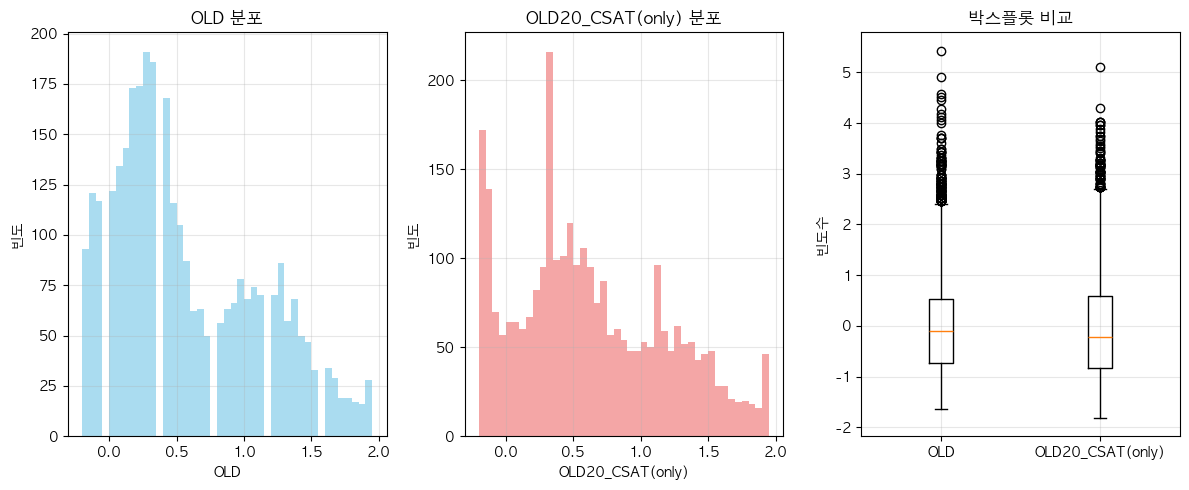

In [54]:
analyzer = analyze_word_frequency_correlation(df, 'OLD', 'OLD20_CSAT(only)', normalize=True, bins=np.arange(-.2, 2, 0.05))

## CSAT vs SUBTLEX

단어 빈도수 상관관계 분석 결과

📊 기본 통계:
데이터 개수: 6827
CSAT_Freq - 평균: -0.00, 표준편차: 1.00
SUBTLWF - 평균: 0.00, 표준편차: 1.00

🔗 상관계수:
피어슨 상관계수: 0.7926 (p-value: 0.0000)
스피어만 상관계수: 0.5953 (p-value: 0.0000)
켄달 타우: 0.4620 (p-value: 0.0000)

📝 해석:
통계적 유의성: 매우 유의함 (p < 0.001)
상관관계 강도: 강한 양의 상관관계


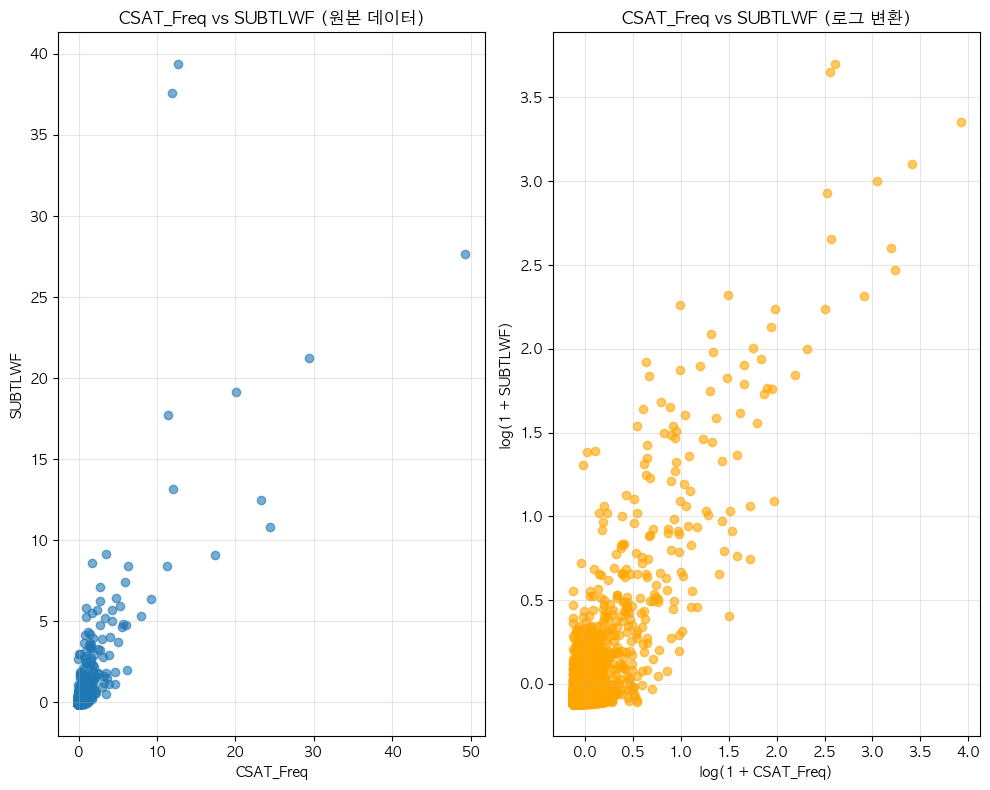

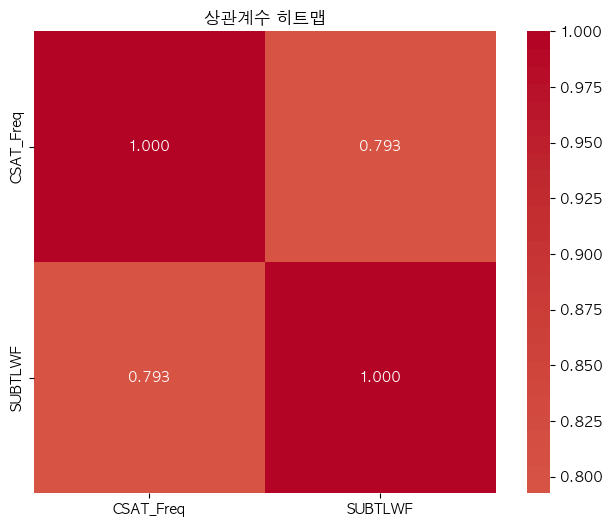

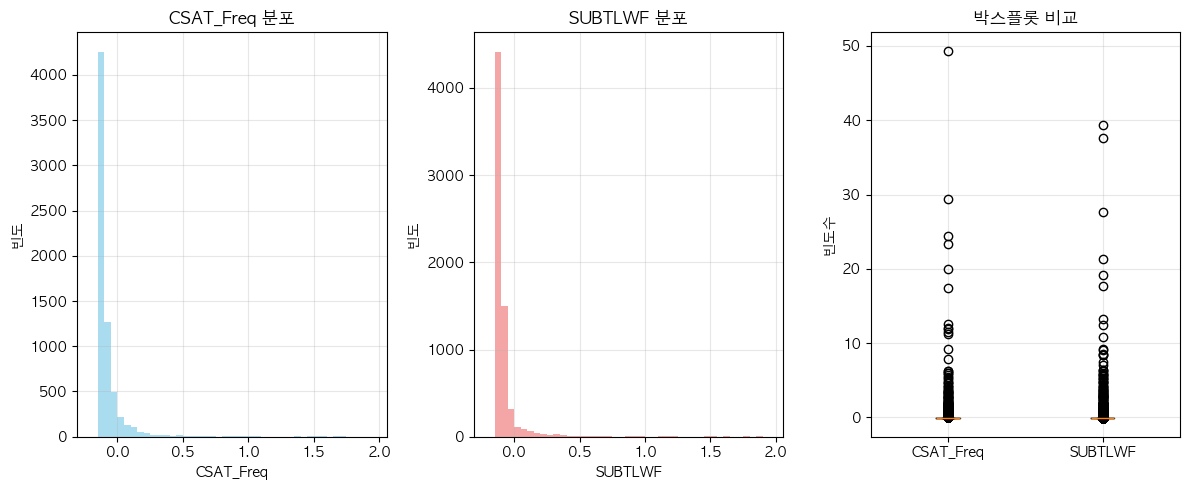

In [51]:
analyzer = analyze_word_frequency_correlation(df, 'CSAT_Freq', 'SUBTLWF', normalize=True, bins=np.arange(-.2, 2, 0.05))